# Clustering Analysis: Population Health Profiling

This notebook applies K-Means clustering to identify population health profiles.

**Purpose**: Discover natural groupings in the population based on health indicators.

**Method**: K-Means clustering
- **Why K-Means?** It's interpretable, scalable, and creates clear group centroids that can be understood by health professionals.
- **Limitations**: Assumes spherical clusters, requires pre-specifying k, sensitive to initialization.

**Important Note**: Clusters may show general trends rather than definitive clinical groups.

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader import load_diabetes_data
from preprocessing import prepare_features_target, scale_features
from clustering import (
    find_optimal_clusters,
    perform_clustering,
    analyze_cluster_characteristics,
    plot_elbow_curve
)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load and Prepare Data

We'll use scaled features for clustering because K-Means is distance-based.

In [2]:
# Load data
df = load_diabetes_data()
X, y = prepare_features_target(df)

# For clustering, we'll use a sample to make computation manageable
# This is a practical choice, not an optimization
np.random.seed(42)
sample_size = 10000
sample_indices = np.random.choice(X.index, size=sample_size, replace=False)
X_sample = X.loc[sample_indices]
y_sample = y.loc[sample_indices]

print(f"Using sample of {sample_size} records for clustering")
print(f"Sample represents {sample_size/len(X)*100:.1f}% of total data")

Dataset loaded successfully from UCI repository
Shape: 253680 rows, 22 columns
Source: https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators
Features shape: (253680, 21)
Target distribution:
Diabetes_binary
0    218334
1     35346
Name: count, dtype: int64
Class imbalance ratio: 6.18:1
Using sample of 10000 records for clustering
Sample represents 3.9% of total data


In [3]:
# Scale features
X_scaled, scaler = scale_features(X_sample)
print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## 2. Determine Number of Clusters

Using the elbow method as a guide.

**Note**: The elbow point is often subjective. We're looking for a reasonable balance, not perfection.

✅ Figure saved: ../outputs/figures/elbow_curve.png


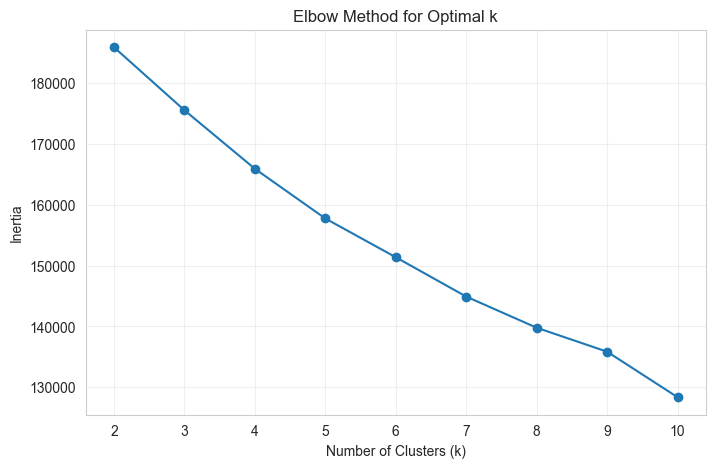

In [4]:
# Find optimal k using elbow method
inertias = find_optimal_clusters(X_scaled, max_k=10)

# Plot elbow curve
plot_elbow_curve(inertias, save_path='../outputs/figures/elbow_curve.png')

# Display the plot

## 3. Perform Clustering

Based on the elbow curve and practical considerations, we'll use **k=3**.

**Justification**: Three clusters align with a common health risk stratification (low/medium/high risk).

In [5]:
# Perform clustering with k=3
kmeans, cluster_labels, sil_score = perform_clustering(X_scaled, n_clusters=3)

print(f"\nSilhouette Score: {sil_score:.3f}")
print("A score closer to 1 indicates well-separated clusters.")
print("A score around 0.2-0.3 is typical for real-world health data.")

Clustering completed with 3 clusters
Silhouette Score: 0.081
Cluster sizes: [3655 1700 4645]

Silhouette Score: 0.081
A score closer to 1 indicates well-separated clusters.
A score around 0.2-0.3 is typical for real-world health data.


## 4. Analyze Cluster Characteristics

What do these clusters represent?

In [6]:
# Get cluster profiles
cluster_profiles = analyze_cluster_characteristics(X_scaled, cluster_labels, X.columns)

print("\nCluster Profiles (scaled values):")
print(cluster_profiles)


Cluster Profiles (scaled values):
           HighBP  HighChol  CholCheck       BMI    Smoker    Stroke  \
Cluster                                                                
0        0.705717  0.465060   0.156553  0.116780  0.202681 -0.019249   
1        0.479370  0.360014   0.089647  0.438801  0.289196  0.554671   
2       -0.730749 -0.497701  -0.155996 -0.252485 -0.265324 -0.187855   

         HeartDiseaseorAttack  PhysActivity    Fruits   Veggies  ...  \
Cluster                                                          ...   
0                    0.090738     -0.048312 -0.050817 -0.070762  ...   
1                    0.644840     -0.674677 -0.242088 -0.258449  ...   
2                   -0.307400      0.284936  0.128587  0.150269  ...   

         AnyHealthcare  NoDocbcCost   GenHlth  MentHlth  PhysHlth  DiffWalk  \
Cluster                                                                       
0             0.102782    -0.178346  0.049329 -0.244713 -0.292684 -0.212931   
1     

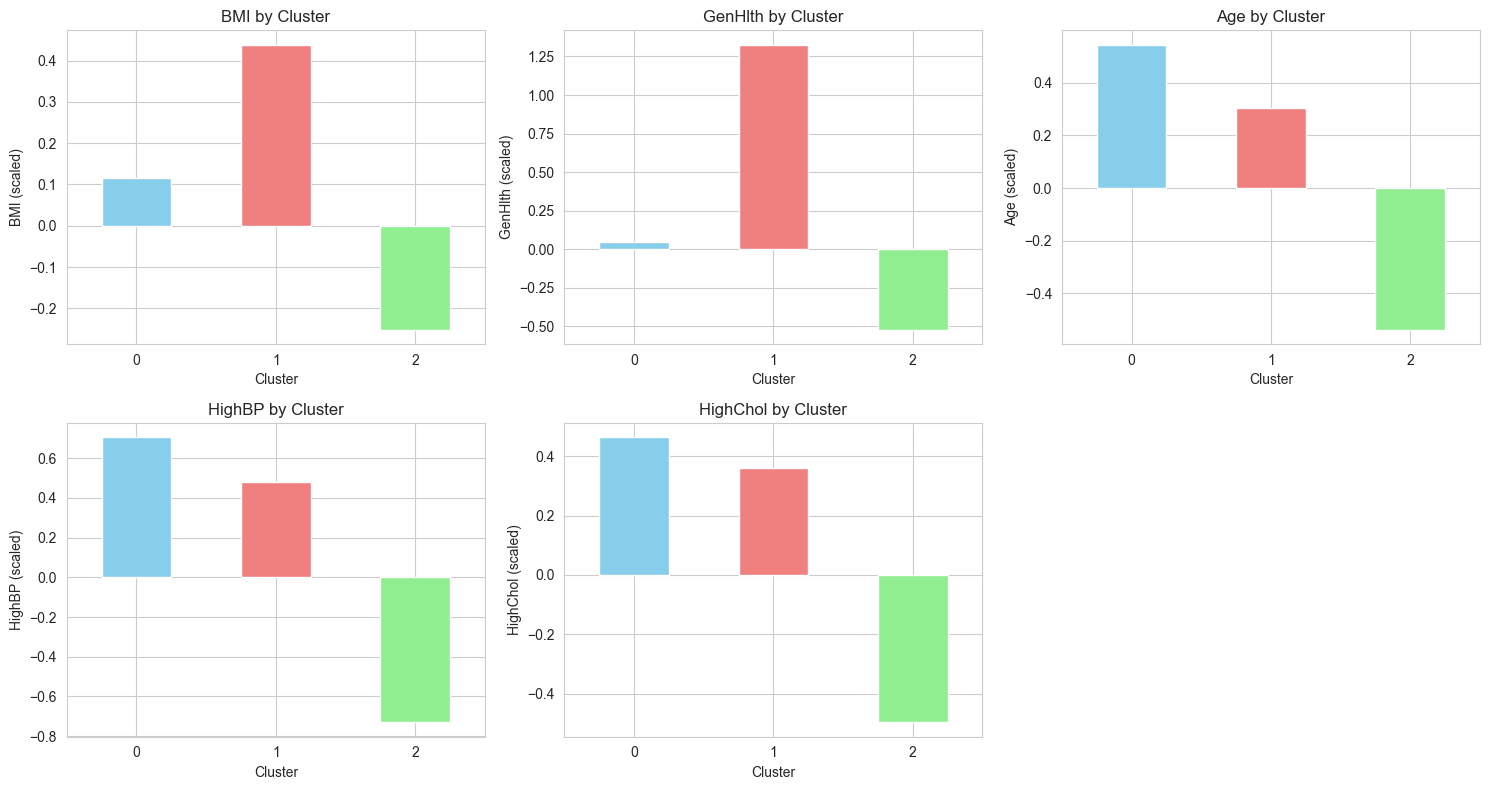

In [7]:
# Visualize key features across clusters
key_features = ['BMI', 'GenHlth', 'Age', 'HighBP', 'HighChol']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    cluster_profiles[feature].plot(kind='bar', ax=axes[idx], color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[idx].set_title(f'{feature} by Cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(f'{feature} (scaled)')
    axes[idx].set_xticklabels([0, 1, 2], rotation=0)

fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('../outputs/figures/cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Cluster Diabetes Distribution

Do clusters align with diabetes prevalence?


Diabetes prevalence by cluster:
         Diabetes_Rate  Count
Cluster                      
0             0.194802   3655
1             0.310000   1700
2             0.026050   4645


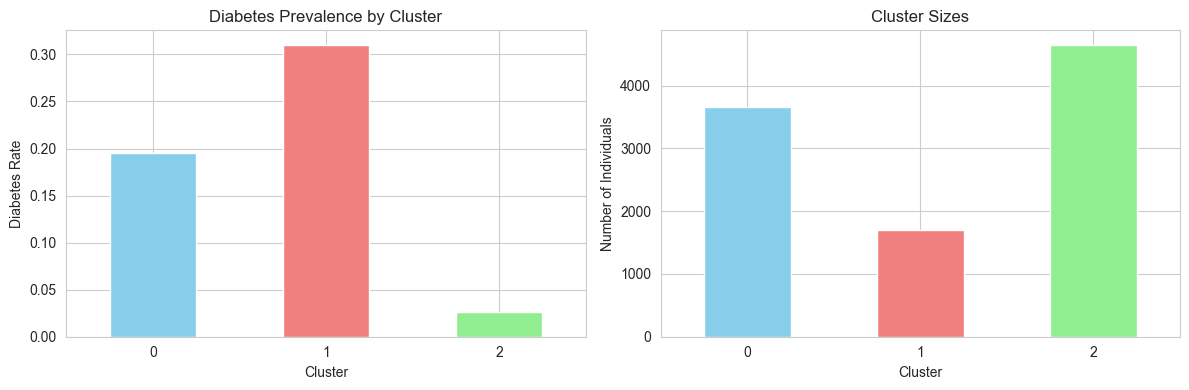

In [8]:
# Add cluster labels to sample data
cluster_df = pd.DataFrame({
    'Cluster': cluster_labels,
    'Diabetes': y_sample.values
})

# Calculate diabetes rate per cluster
diabetes_by_cluster = cluster_df.groupby('Cluster')['Diabetes'].agg(['mean', 'count'])
diabetes_by_cluster.columns = ['Diabetes_Rate', 'Count']

print("\nDiabetes prevalence by cluster:")
print(diabetes_by_cluster)

# Visualize
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

diabetes_by_cluster['Diabetes_Rate'].plot(kind='bar', ax=ax[0], color=['skyblue', 'lightcoral', 'lightgreen'])
ax[0].set_title('Diabetes Prevalence by Cluster')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Diabetes Rate')
ax[0].set_xticklabels([0, 1, 2], rotation=0)

diabetes_by_cluster['Count'].plot(kind='bar', ax=ax[1], color=['skyblue', 'lightcoral', 'lightgreen'])
ax[1].set_title('Cluster Sizes')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Number of Individuals')
ax[1].set_xticklabels([0, 1, 2], rotation=0)

plt.tight_layout()
plt.savefig('../outputs/figures/diabetes_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary and Reflection

**Findings**:
1. K-Means identified 3 distinct population groups
2. Clusters show varying diabetes prevalence rates
3. Silhouette score suggests moderate cluster separation

**Interpretation Challenges**:
- Clusters represent statistical groupings, not clinical diagnoses
- The boundaries between clusters are not sharp in reality
- Health risk exists on a continuum, not in discrete categories

**Practical Implications**:
- These clusters could inform population-level health interventions
- However, individual risk assessment requires more nuanced approaches
- The clustering assumes all features are equally important, which may not reflect clinical reality

**Ethical Considerations**:
- Grouping individuals may oversimplify complex health profiles
- Survey-based data may not represent all demographic groups equally
- Risk stratification could lead to differential treatment if not applied carefully